In [1]:
# Conectar ao MySQL e lidar com .env
!pip install mysql-connector-python python-dotenv pandas

# Visualização de dados
!pip install matplotlib

# Modelos de regressão e métricas
!pip install scikit-learn

!pip install lightgbm 


In [2]:
import os
import mysql.connector
from dotenv import load_dotenv

load_dotenv()

DB_HOST = os.getenv("DB_HOST")
DB_USER = os.getenv("DB_USER")
DB_PASS = os.getenv("DB_PASS")
DB_NAME = os.getenv("DB_NAME")
DB_PORT = int(os.getenv("DB_PORT", 3306))

print("🔗 Conectando no banco...")

conn = mysql.connector.connect(
    host=DB_HOST,
    user=DB_USER,
    password=DB_PASS,
    database=DB_NAME,
    port=DB_PORT
)

cursor = conn.cursor()
print("✅ Conectado com sucesso!")


🔗 Conectando no banco...
✅ Conectado com sucesso!


In [3]:
cursor.execute("SHOW TABLES;")
for table in cursor.fetchall():
    print(table)


('rais_2014',)
('rais_2015',)
('rais_2016',)
('rais_2017',)
('rais_2018',)
('rais_2019',)
('rais_2020',)
('rais_2021',)
('rais_2022',)
('rais_2023',)
('rais_2024',)
('vinculos',)


In [4]:
import pandas as pd

df = pd.read_sql("SELECT * FROM vinculos LIMIT 10;", conn)
df.columns


/tmp/ipykernel_5733/2707313518.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM vinculos LIMIT 10;", conn)


Index(['id_municipio_trabalho', 'ano', 'mes_admissao', 'mes_desligamento',
       'cnae_1', 'subatividade_ibge', 'subsetor_ibge', 'descricao_subsetor',
       'tipo_salario', 'cbo_2002', 'total_empregos', 'media_remuneracao',
       'media_idade', 'tamanho_estabelecimento', 'tipo_estabelecimento',
       'natureza_juridica'],
      dtype='object')

In [5]:
df = pd.read_sql("SELECT * FROM rais_2024 LIMIT 10;", conn)
df.columns

/tmp/ipykernel_5733/4044311474.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM rais_2024 LIMIT 10;", conn)


Index(['Mun Trab', 'Município', 'Mês Admissão', 'Mês Desligamento',
       'CNAE 2.0 Classe', 'CNAE 95 Classe', 'IBGE Subsetor', 'Tipo Vínculo',
       'CBO Ocupação 2002', 'Vl Remun Média Nom', 'Idade',
       'Tamanho Estabelecimento', 'Tipo Estab', 'Natureza Jurídica'],
      dtype='object')

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==============================
# Carregar dados do banco
# ==============================

query = """
SELECT
    ano,
    mes_admissao AS mes,
    SUM(total_empregos) AS total_empregos,
    AVG(media_remuneracao) AS media_remuneracao,
    AVG(media_idade) AS media_idade,
    AVG(tamanho_estabelecimento) AS tamanho_estabelecimento
FROM vinculos
GROUP BY ano, mes_admissao
ORDER BY ano, mes_admissao;
"""

df = pd.read_sql(query, conn)

# ==============================
# Pré-processamento inicial
# ==============================

# Salvar coluna original para gráficos
df['mes_original'] = df['mes']

# Garantir tipos corretos
df['ano'] = df['ano'].astype(int)
df['mes'] = df['mes'].astype(float)  # manter como float para tratar nulos

# Remover linhas com mês nulo (ou imputar, se fizer sentido)
df = df.dropna(subset=['mes'])

# Converter mês para inteiro após limpeza
df['mes'] = df['mes'].astype(int)

# Ordenar para garantir consistência temporal
df = df.sort_values(['ano', 'mes']).reset_index(drop=True)

/tmp/ipykernel_5733/429440061.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [7]:
# ==============================
# Criar target e features temporais
# ==============================

# Garantir ordenação temporal antes de aplicar shift
df = df.sort_values(['ano', 'mes']).reset_index(drop=True)

# Target: total de empregos do próximo mês
df['vagas_proximo_mes'] = df['total_empregos'].shift(-1)

# Sazonalidade cíclica (mês como ângulo)
df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)

# Diferença mês a mês
df['delta_empregos'] = df['total_empregos'].diff()

# Médias móveis (sem preenchimento agressivo)
df['media_movel_3m'] = df['total_empregos'].rolling(window=3).mean()
df['media_movel_6m'] = df['total_empregos'].rolling(window=6).mean()
df['media_movel_12m'] = df['total_empregos'].rolling(window=12).mean()

# Feature "mês crítico" (abril e setembro)
mes_criticos = [4, 9]
df['mes_critico'] = df['mes_original'].astype(int).isin(mes_criticos).astype(int)

# Total de empregos no mesmo mês do ano anterior
df['total_empregos_mes_ano_passado'] = df['total_empregos'].shift(12)


In [8]:
# ==============================
# Criar lags e dummies de mês
# ==============================

# Garantir ordenação temporal antes de aplicar lags
df = df.sort_values(['ano', 'mes']).reset_index(drop=True)

# Criar lags de total_empregos
lag_list = [1, 2, 3, 6, 12]
for lag in lag_list:
    df[f'total_empregos_lag{lag}'] = df['total_empregos'].shift(lag)

# Criar dummies de mês (evita multicolinearidade com drop_first)
df = pd.get_dummies(df, columns=['mes'], prefix='mes', drop_first=True)

# Remover linhas com NaN nas lags e na feature anual
lag_cols = [f'total_empregos_lag{lag}' for lag in lag_list] + ['total_empregos_mes_ano_passado']
before_drop = df.shape[0]
df.dropna(subset=lag_cols, inplace=True)
after_drop = df.shape[0]
print(f"Linhas removidas por NaN em lags: {before_drop - after_drop}")

# Visualizar primeiras linhas
df.head()


Linhas removidas por NaN em lags: 12


,ano,total_empregos,media_remuneracao,media_idade,tamanho_estabelecimento,mes_original,vagas_proximo_mes,mes_sin,mes_cos,delta_empregos,...,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
12,2011,2448.0,1279.576873,31.786511,5.2804,1.0,2084.0,0.500000,8.660254e-01,970.0,...,False,False,False,False,False,False,False,False,False,False
13,2011,2084.0,1185.960298,32.115987,5.4911,2.0,1797.0,0.866025,5.000000e-01,-364.0,...,False,False,False,False,False,False,False,False,False,False
14,2011,1797.0,1238.590792,32.203625,5.3885,3.0,1772.0,1.000000,6.123234e-17,-287.0,...,True,False,False,False,False,False,False,False,False,False
15,2011,1772.0,1228.014265,31.804502,5.5118,4.0,2043.0,0.866025,-5.000000e-01,-25.0,...,False,True,False,False,False,False,False,False,False,False
16,2011,2043.0,1267.353859,32.046560,5.5380,5.0,2202.0,0.500000,-8.660254e-01,271.0,...,False,False,True,False,False,False,False,False,False,False


In [9]:
# # ==============================
# # Separar treino e teste
# # ==============================

# # Treino: anos anteriores a 2024
# train = df[df['ano'] < 2023].copy()
# # Teste: ano 2024
# test = df[df['ano'] == 2023].copy()

# # Verificar distribuição temporal
# print("Treino - anos:", sorted(train['ano'].unique()))
# print("Teste - anos:", sorted(test['ano'].unique()))

# # ==============================
# # Definir features
# # ==============================
# features = [
#     'media_remuneracao', 'media_idade', 'tamanho_estabelecimento',
#     'mes_sin', 'mes_cos', 'delta_empregos',
#     'media_movel_3m', 'media_movel_6m', 'media_movel_12m',
#     'mes_critico', 'total_empregos_mes_ano_passado'
# ]

# # Adicionar lags
# features += [f'total_empregos_lag{lag}' for lag in [1, 2, 3, 6, 12]]

# # Adicionar dummies de mês
# month_dummies = [col for col in df.columns if col.startswith('mes_')]
# features += month_dummies

# # Remover duplicatas
# features = list(dict.fromkeys(features))

# # ==============================
# # Filtrar dados com base nas features e target
# # ==============================
# before_train = train.shape[0]
# train = train.dropna(subset=features + ['vagas_proximo_mes'])
# after_train = train.shape[0]

# before_test = test.shape[0]
# test = test.dropna(subset=features + ['vagas_proximo_mes'])
# after_test = test.shape[0]

# print(f"Treino: removidas {before_train - after_train} linhas com NaN")
# print(f"Teste : removidas {before_test - after_test} linhas com NaN")

# # ==============================
# # Separar X e y
# # ==============================
# X_train = train[features]
# y_train = train['vagas_proximo_mes']
# X_test = test[features]
# y_test = test['vagas_proximo_mes']

# # Conferir shapes
# print("Shape X_train:", X_train.shape)
# print("Shape X_test :", X_test.shape)
# print("Shape y_train:", y_train.shape)
# print("Shape y_test :", y_test.shape)


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
import numpy as np

# ==============================
# Definir features
# ==============================

features = [
    'media_remuneracao', 'media_idade', 'tamanho_estabelecimento',
    'mes_sin', 'mes_cos', 'delta_empregos',
    'media_movel_3m', 'media_movel_6m', 'media_movel_12m',
    'mes_critico',
    'total_empregos_mes_ano_passado'
]

features += [f'total_empregos_lag{lag}' for lag in [1, 2, 3, 6, 12]]
features += [col for col in df.columns if col.startswith('mes_')]
features = list(dict.fromkeys(features))

# ==============================
# Validação cruzada temporal
# ==============================

anos_disponiveis = sorted(df['ano'].unique())
resultados = []

for ano_teste in anos_disponiveis:
    ano_treino = [a for a in anos_disponiveis if a < ano_teste]
    if len(ano_treino) < 2:
        continue  # pula se treino for muito pequeno

    train = df[df['ano'].isin(ano_treino)].copy()
    test = df[df['ano'] == ano_teste].copy()

    train = train.dropna(subset=features + ['vagas_proximo_mes'])
    test = test.dropna(subset=features + ['vagas_proximo_mes'])

    X_train = train[features]
    y_train = train['vagas_proximo_mes']
    X_test = test[features]
    y_test = test['vagas_proximo_mes']

    model = LGBMRegressor(
        objective='regression',
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=15,
        max_depth=6,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    resultados.append({
        'ano_teste': ano_teste,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    })

# ==============================
# Exibir resultados
# ==============================

print("\nResultados da validação cruzada temporal:")
for r in resultados:
    print(f"Ano {r['ano_teste']}: R²={r['r2']:.2f} | RMSE={r['rmse']:.2f} | MAE={r['mae']:.2f}")


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 24, number of used features: 0
[LightGBM] [Info] Start training from score 3358.916667
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

In [11]:
from lightgbm import early_stopping, log_evaluation

model = LGBMRegressor(
    objective='regression',
    n_estimators=1000,
    learning_rate=0.03,
    num_leaves=15,
    max_depth=6,
    min_child_samples=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=50)
    ]
)

# Previsão com melhor iteração
y_pred = model.predict(X_test, num_iteration=model.best_iteration_)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 744
[LightGBM] [Info] Number of data points in the train set: 156, number of used features: 28
[LightGBM] [Info] Start training from score 3291.858974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [12]:
# ==============================
# Avaliar desempenho do modelo
# ==============================

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calcular métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Exibir resultados
print("Desempenho do modelo:")
print(f"  MSE  : {mse:.2f}")   # Erro quadrático médio
print(f"  RMSE : {rmse:.2f}")  # Raiz do erro quadrático médio
print(f"  MAE  : {mae:.2f}")   # Erro absoluto médio
print(f"  R²   : {r2:.2f}")    # Coeficiente de determinação


Desempenho do modelo:
  MSE  : 444309.13
  RMSE : 666.57
  MAE  : 540.69
  R²   : -0.04


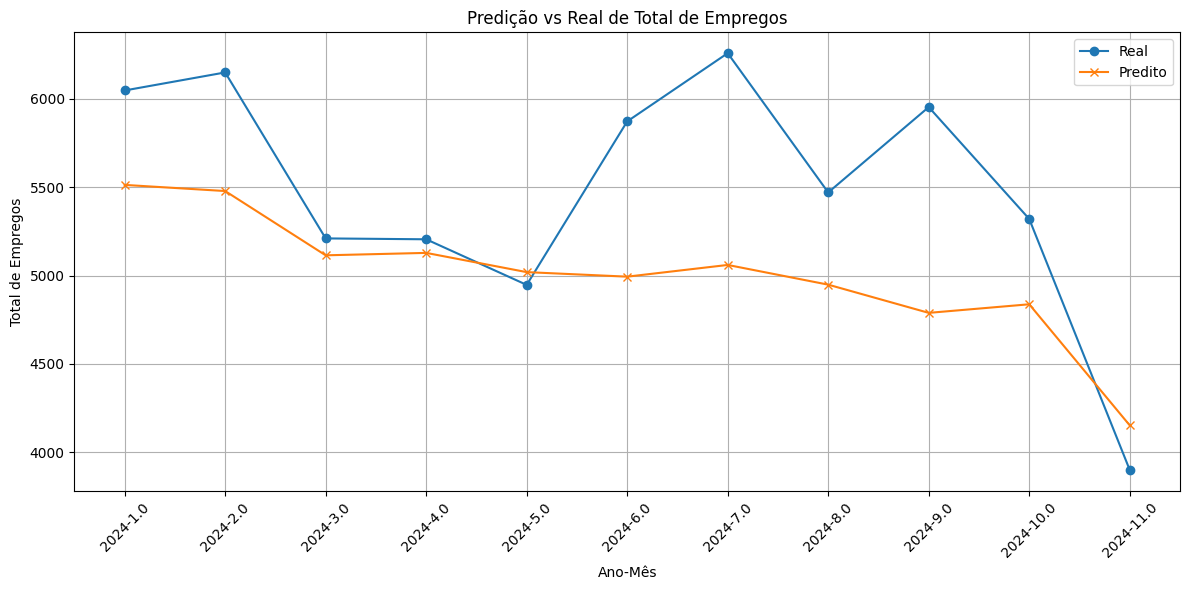

In [13]:
# ==============================
# Plotar predição vs realidade
# ==============================

plt.figure(figsize=(12,6))

# Construir eixo x usando coluna original 'mes_original'
x_axis = test['ano'].astype(str) + '-' + test['mes_original'].astype(str).str.zfill(2)

# Plotar valores reais e preditos
plt.plot(x_axis, y_test, label='Real', marker='o')
plt.plot(x_axis, y_pred, label='Predito', marker='x')

# Configurações do gráfico
plt.xticks(rotation=45)
plt.title('Predição vs Real de Total de Empregos')
plt.xlabel('Ano-Mês')
plt.ylabel('Total de Empregos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
# Último mês com dados reais
ultimo_mes_real = df[df['ano'] == 2024].sort_values('mes_original').iloc[-1]

# Criar estrutura para meses futuros
meses_futuros = [6, 7, 8, 9, 10, 11, 12]
futuro = pd.DataFrame({
    'ano': [2025]*len(meses_futuros),
    'mes_original': meses_futuros,
    'media_remuneracao': [df['media_remuneracao'].mean()]*len(meses_futuros),
    'media_idade': [df['media_idade'].mean()]*len(meses_futuros),
    'tamanho_estabelecimento': [df['tamanho_estabelecimento'].mean()]*len(meses_futuros),
    'delta_empregos': [0]*len(meses_futuros),  # neutro
    'media_movel_3m': [ultimo_mes_real['media_movel_3m']]*len(meses_futuros),
    'media_movel_6m': [ultimo_mes_real['media_movel_6m']]*len(meses_futuros),
    'media_movel_12m': [ultimo_mes_real['media_movel_12m']]*len(meses_futuros),
    'total_empregos_mes_ano_passado': [df[(df['ano'] == 2024) & (df['mes_original'] == m)]['total_empregos'].values[0] if not df[(df['ano'] == 2024) & (df['mes_original'] == m)].empty else df['total_empregos'].mean() for m in meses_futuros],
    'mes_critico': [1 if m in [4, 9] else 0 for m in meses_futuros],
    'mes_sin': [np.sin(2 * np.pi * m / 12) for m in meses_futuros],
    'mes_cos': [np.cos(2 * np.pi * m / 12) for m in meses_futuros]
})

# Preencher lags com os últimos valores reais
for lag in [1, 2, 3, 6, 12]:
    futuro[f'total_empregos_lag{lag}'] = ultimo_mes_real['total_empregos']

# Adicionar dummies de mês
for m in range(1, 13):
    col = f'mes_{m}'
    futuro[col] = [1 if mes == m else 0 for mes in meses_futuros]

# Remover dummies duplicadas
futuro = futuro[[f for f in features if f in futuro.columns]]

# Prever
y_futuro = model.predict(futuro)

# Exibir resultados
for mes, pred in zip(meses_futuros, y_futuro):
    print(f"Previsão para 2025-{mes:02d}: {int(pred):,} vagas")


Previsão para 2025-06: 4,791 vagas
Previsão para 2025-07: 4,819 vagas
Previsão para 2025-08: 4,590 vagas
Previsão para 2025-09: 4,574 vagas
Previsão para 2025-10: 4,549 vagas
Previsão para 2025-11: 4,073 vagas
Previsão para 2025-12: 5,301 vagas
